# Node Response

In [1]:
import numpy as np
import openseespy.opensees as ops
import opstool as opst
import matplotlib.pyplot as plt

We load a suspension bridge model and visualize it:

OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-None.nc!

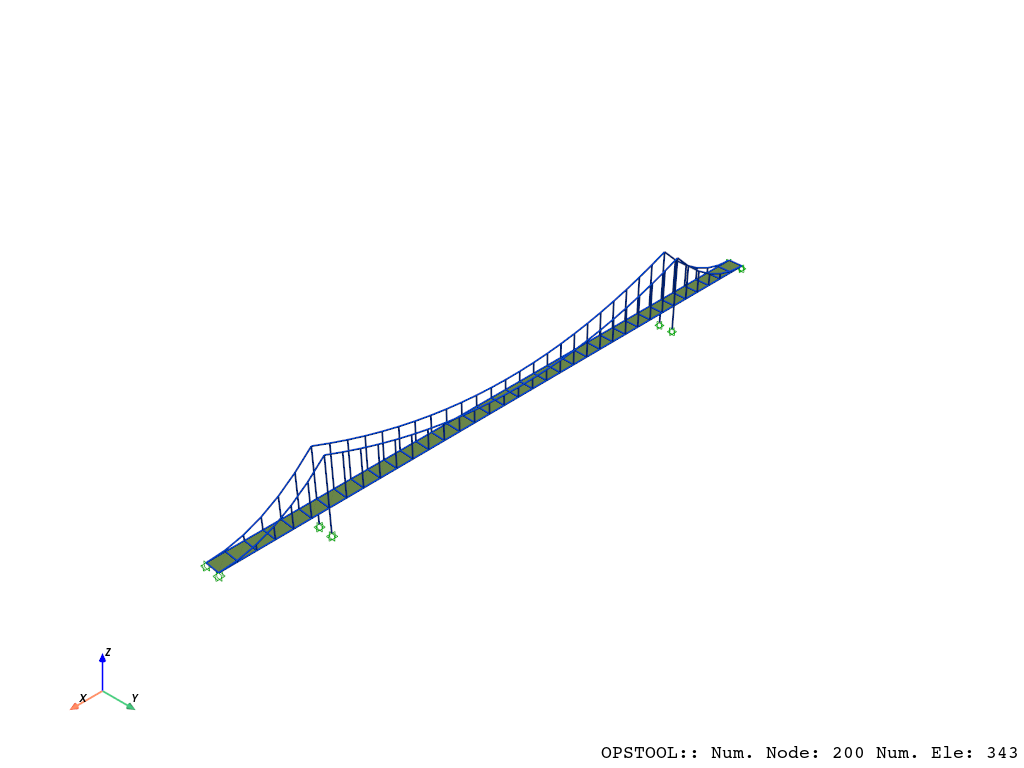

In [2]:
opst.load_ops_examples("suspensionbridge")  # or your model code here


# plot
opst.vis.pyvista.set_plot_props(notebook=True)
fig = opst.vis.pyvista.plot_model(show_nodal_loads=True, show_ele_loads=True)
fig.show(jupyter_backend="static")

## Result Saving

In [3]:
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
opst.pre.gen_grav_load(direction="Z", factor=-9.81)

In [4]:
ops.system("BandGeneral")
# Create the constraint handler, the transformation method
ops.constraints("Transformation")
# Create the DOF numberer, the reverse Cuthill-McKee algorithm
ops.numberer("RCM")
# Create the convergence test, the norm of the residual with a tolerance of
# 1e-12 and a max number of iterations of 10
ops.test("NormDispIncr", 1.0e-12, 10, 3)
# Create the solution algorithm, a Newton-Raphson algorithm
ops.algorithm("Newton")
# Create the integration scheme, the LoadControl scheme using steps of 0.1
ops.integrator("LoadControl", 0.1)
# Create the analysis object
ops.analysis("Static")

In [5]:
ODB = opst.post.CreateODB(odb_tag=1)
for i in range(10):
    ops.analyze(1)
    ODB.fetch_response_step()
ODB.save_response()

OPSTOOL ::  All responses data with odb_tag = 1 saved in _OPSTOOL_ODB/RespStepData-1.nc!

## Result Reading

### Displacement

For example, to read displacements, you can use the following:

In [6]:
node_disp = opst.post.get_nodal_responses(odb_tag=1, resp_type="disp")

OPSTOOL ::  Loading response data from _OPSTOOL_ODB/RespStepData-1.nc ...

In [7]:
node_disp.dims

('time', 'nodeTags', 'DOFs')

To retrieve the coordinates for each dimension, you can use the following:

In [8]:
print(node_disp.coords["time"].data)
print()
print(node_disp.coords["DOFs"].data)
print()
print(node_disp.coords["nodeTags"].data)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]

['UX' 'UY' 'UZ' 'RX' 'RY' 'RZ']

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200]


The ``.sel`` method can be used to retrieve specific elements corresponding to a particular dimension.
For example, the following code retrieves the three translational displacements of node 100:

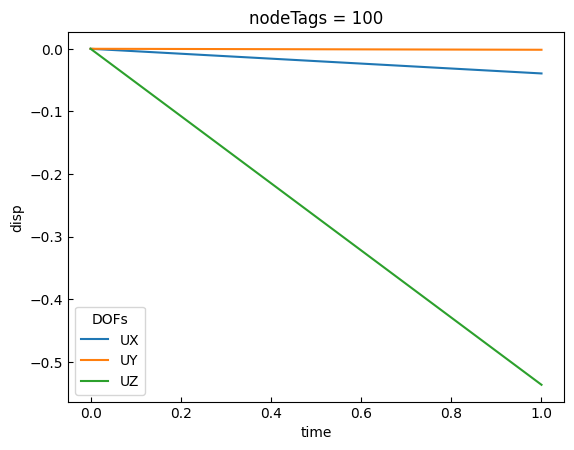

In [9]:
data = node_disp.sel(nodeTags=100, DOFs=["UX", "UY", "UZ"])
data.plot.line(x="time")
plt.show()

We can also perform array operations using libraries like NumPy. For example, the following code computes the L2 norm:

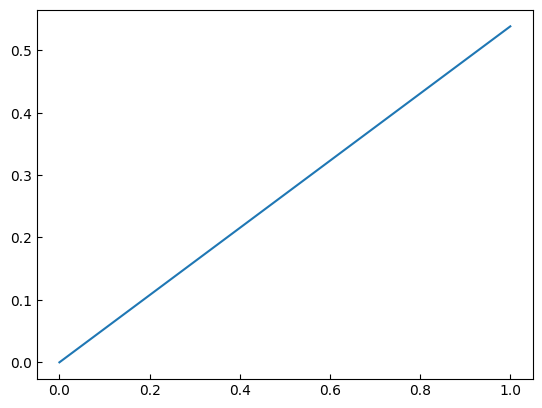

In [10]:
times = node_disp.coords["time"].data
disp = np.linalg.norm(data, axis=-1)
plt.plot(times, disp)
plt.show()

### Reaction forces

We can also retrieve reaction forces and perform operations on them. For example:

In [11]:
node_react = opst.post.get_nodal_responses(odb_tag=1, resp_type="reaction")

OPSTOOL ::  Loading response data from _OPSTOOL_ODB/RespStepData-1.nc ...

In [12]:
node_react

<xarray.DataArray 'reaction' (time: 11, nodeTags: 200, DOFs: 6)> Size: 106kB
[13200 values with dtype=float64]
Coordinates:
  * nodeTags  (nodeTags) int32 800B 1 2 3 4 5 6 7 ... 195 196 197 198 199 200
  * DOFs      (DOFs) <U2 48B 'UX' 'UY' 'UZ' 'RX' 'RY' 'RZ'
  * time      (time) float64 88B 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0

In practice, we are more interested in computing the total reaction force. 
This can be achieved by applying a summation method. 
The provided ``nodeTags`` dimension indicates that the summation is performed over all nodes. 

For example:

In [13]:
node_react = node_react.sum(dim="nodeTags", skipna=True)
node_react

<xarray.DataArray 'reaction' (time: 11, DOFs: 6)> Size: 528B
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.06581410e-14, -2.80721626e-15,  2.42759647e+02,
         1.66196383e-10,  1.55935931e-10, -3.25433423e-14],
       [ 5.68434189e-14, -5.09575021e-15,  4.85519293e+02,
        -3.29001104e-10,  1.04909414e-10,  1.89685562e-13],
       [ 1.63424829e-13, -1.61589492e-14,  7.28278940e+02,
        -4.66395850e-10,  1.58973279e-10,  6.59047965e-13],
       [-3.55271368e-14, -1.40165657e-14,  9.71038586e+02,
        -3.35567956e-10,  6.19882812e-10, -1.65233804e-12],
       [-9.94759830e-14, -2.14168960e-14,  1.21379823e+03,
        -6.78114698e-10, -4.70717687e-10,  1.02813523e-12],
       [ 1.03739239e-12, -1.48336204e-14,  1.45655788e+03,
         2.46920622e-10,  1.32551747e-09, -1.52279643e-12],
       [ 3.83693077e-13, -3.17385007e-14,  1.69931753e+03,
         1.74344947e-09, -7.13857418e-10, -1.23296581e-12],
       [ 1.84741111e-13, -6.36123099e-15,  1.94207717e+03,
        -1.52654076e-09,  2.65931277e-10, -2.86352941e-12],
       [-5.96855898e-13, -1.15844834e-14,  2.18483682e+03,
        -2.46029202e-09,  2.23074892e-11,  1.28721217e-12],
       [ 1.70530257e-13, -1.65180369e-14,  2.42759647e+03,
         1.79619594e-09, -3.51480622e-10,  2.14169119e-12]])
Coordinates:
  * DOFs     (DOFs) <U2 48B 'UX' 'UY' 'UZ' 'RX' 'RY' 'RZ'
  * time     (time) float64 88B 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0

Since gravity loads are applied in the Z direction, we retrieve the total reaction forces in the Z direction:

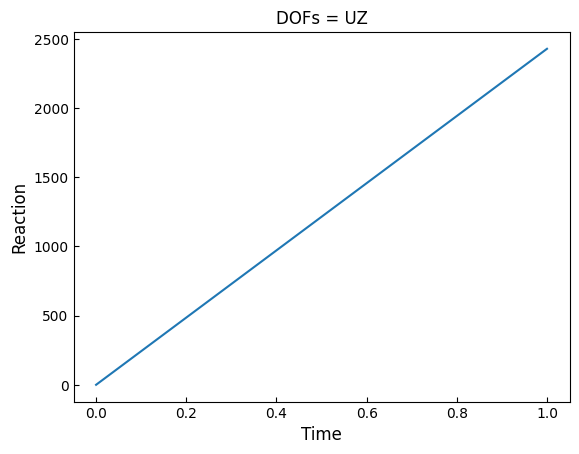

In [14]:
node_react_uz = node_react.sel(DOFs="UZ")
node_react_uz.plot.line(x="time")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Reaction", fontsize=12)
plt.show()